#### El código de styleGan fue modificado parcialmente del repositorio de github: 
https://github.com/TAUIL-Abd-Elilah/Generative-Adversarial-Networks--GANs/blob/main/StyleGAN%20implementation%20from%20scratch%20PyTorch.ipynb

#### Se cargan las bibliotecas

In [1]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.utils import save_image
from math import log2
import numpy as np
import os
from tqdm import tqdm
import matplotlib.pylab as plt

#### Definimos parámetros de la arquitectura y del entrenamiento

In [2]:
#DATSET = './celeba_hq/val_2/' #Tomamos un dataset más pequeño si queremos hacer pruebas

DATSET = './celeba_hq/train/'

START_TRAIN_IMG_SIZE = 4
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
LR = 1e-3
#BATCH_SIZES = [256,256,128,64,32,16]
#Los batches son demasiado grandes
#BATCH_SIZES = [512, 256, 128, 64, 32, 16, 8, 4, 2]

#Falla para resolucion 32x32 y 512x512
#BATCH_SIZES = [256, 128, 64, 32, 16, 8, 4, 2, 1]

#BATCH_SIZES = [256, 128, 64, 16, 16, 8, 4, 1, 1]

#Sólo vamos a entrenar hasta resolución 256x256 píxeles porque el entrenamiento es extremadamente costoso computacionalmente
BATCH_SIZES = [256, 128, 64, 16, 16, 8, 4]

CHANNELS_IMG = 3
Z_DIm = 512
Z_DIM = 512
W_DIM = 512
IN_CHANNELS = 512
LAMBDA_GP = 10
#Bajamos el número de épocas de 30 a 25. Se entrenan 25 eṕocas sobre el dataset de CelebA-HQ para cada aumento progresivo
PROGRESSIVE_EPOCHS = [25] * len(BATCH_SIZES)

In [3]:
def get_loader(image_size):
    trainsform = transforms.Compose(
        [transforms.Resize((image_size, image_size)),
         transforms.ToTensor(),
         transforms.RandomHorizontalFlip(p=0.5),
         transforms.Normalize(
            [0.5 for _ in range(CHANNELS_IMG)],
            [0.5 for _ in range(CHANNELS_IMG)],
         )
        ]
    )
    batch_size = BATCH_SIZES[int(log2(image_size/4))]
    dataset = datasets.ImageFolder(root=DATSET, transform=trainsform)
    loader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True
    )
    return loader, dataset

#### Se muestran algunas imágenes del dataset de CelebA-HQ

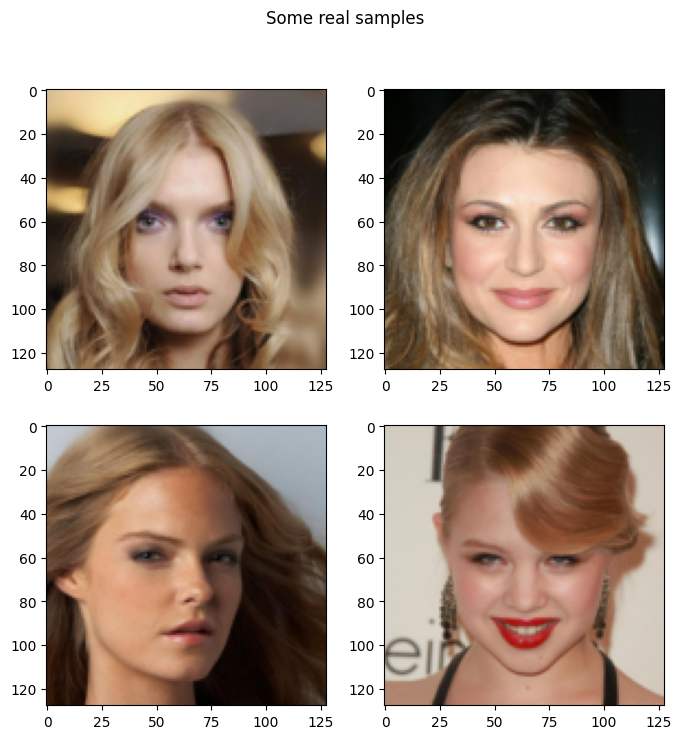

In [4]:
def check_loader():
    loader,_ = get_loader(128)
    cloth,_  = next(iter(loader))
    _,ax     = plt.subplots(2,2,figsize=(8,8))
    plt.suptitle('Some real samples')
    ind = 0
    for k in range(2):
        for kk in range(2):
            ax[k][kk].imshow((cloth[ind].permute(1,2,0)+1)/2)
            ind +=1
check_loader() 

#### Se definen los factores adecuados para el crecimiento progresivo

In [5]:
factors = [1,1,1,1,1/2,1/4,1/8,1/16,1/32]

#### Se definen partes esenciales de la arquitectura

In [6]:
class WSLinear(nn.Module):
    def __init__(
        self, in_features, out_features
    ):
        super(WSLinear,self).__init__()
        self.linear = nn.Linear(in_features, out_features)
        self.scale  = (2/in_features) ** 0.5
        self.bias   = self.linear.bias
        self.linear.bias = None

        nn.init.normal_(self.linear.weight)
        nn.init.zeros_(self.bias)

    def forward(self,x):
        return self.linear(x * self.scale) + self.bias


In [7]:
class PixenNorm(nn.Module):
    def __init__(self):
        super(PixenNorm, self).__init__()
        self.epsilon = 1e-8
    def forward(self,x ):
        return x / torch.sqrt(torch.mean(x**2, dim=1, keepdim=True)+  self.epsilon)


In [8]:
class MappingNetwork(nn.Module):
    def __init__(self, z_dim, w_dim):
        super().__init__()
        self.mapping = nn.Sequential(
            PixenNorm(),
            WSLinear(z_dim, w_dim),
            nn.ReLU(),
            WSLinear(w_dim, w_dim),
            nn.ReLU(),
            WSLinear(w_dim, w_dim),
            nn.ReLU(),
            WSLinear(w_dim, w_dim),
            nn.ReLU(),
            WSLinear(w_dim, w_dim),
            nn.ReLU(),
            WSLinear(w_dim, w_dim),
            nn.ReLU(),
            WSLinear(w_dim, w_dim),
            nn.ReLU(),
            WSLinear(w_dim, w_dim),
        )
    
    def forward(self,x):
        return self.mapping(x)

In [9]:
class AdaIN(nn.Module):
    def __init__(self, channels, w_dim):
        super().__init__()
        self.instance_norm = nn.InstanceNorm2d(channels)
        self.style_scale   = WSLinear(w_dim, channels)
        self.style_bias    = WSLinear(w_dim, channels)

    def forward(self,x,w):
        x = self.instance_norm(x)
        style_scale = self.style_scale(w).unsqueeze(2).unsqueeze(3)
        style_bias  = self.style_bias(w).unsqueeze(2).unsqueeze(3)
        return style_scale * x + style_bias


In [10]:
class injectNoise(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.weight = nn.Parameter(torch.zeros(1,channels,1,1))

    def forward(self, x):
        noise = torch.randn((x.shape[0], 1, x.shape[2], x.shape[3]), device = x.device)
        return x + self.weight + noise


In [11]:
class GenBlock(nn.Module):
    def __init__(self, in_channel, out_channel, w_dim):
        super(GenBlock, self).__init__()
        self.conv1 = WSConv2d(in_channel, out_channel)
        self.conv2 = WSConv2d(out_channel, out_channel)
        self.leaky = nn.LeakyReLU(0.2, inplace=True)
        self.inject_noise1 = injectNoise(out_channel)
        self.inject_noise2 = injectNoise(out_channel)
        self.adain1 = AdaIN(out_channel, w_dim)
        self.adain2 = AdaIN(out_channel, w_dim)
    def forward(self, x,w):
        x = self.adain1(self.leaky(self.inject_noise1(self.conv1(x))), w)
        x = self.adain2(self.leaky(self.inject_noise2(self.conv2(x))), w)
        return x


In [12]:
class Generator(nn.Module):
    def __init__(self, z_dim, w_dim, in_channels, img_channels=3):
        super().__init__()
        self.starting_cte = nn.Parameter(torch.ones(1, in_channels, 4,4))
        self.map = MappingNetwork(z_dim, w_dim)
        self.initial_adain1 = AdaIN(in_channels, w_dim)
        self.initial_adain2 = AdaIN(in_channels, w_dim)
        self.initial_noise1 = injectNoise(in_channels)
        self.initial_noise2 = injectNoise(in_channels)
        self.initial_conv   = nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1)
        self.leaky          = nn.LeakyReLU(0.2, inplace=True)

        self.initial_rgb    = WSConv2d(
            in_channels, img_channels, kernel_size = 1, stride=1, padding=0
        )
        self.prog_blocks, self.rgb_layers = (
            nn.ModuleList([]),
            nn.ModuleList([self.initial_rgb])
        )

        for i in range(len(factors)-1):
            conv_in_c  = int(in_channels * factors[i])
            conv_out_c = int(in_channels * factors[i+1])
            self.prog_blocks.append(GenBlock(conv_in_c, conv_out_c, w_dim))
            self.rgb_layers.append(WSConv2d(conv_out_c, img_channels, kernel_size = 1, stride=1, padding=0))
        
    def fade_in(self, alpha, upscaled, generated):
        return torch.tanh(alpha * generated + (1-alpha ) * upscaled)

    def forward(self, noise, alpha, steps):
        w = self.map(noise)
        x = self.initial_adain1(self.initial_noise1(self.starting_cte),w)
        x = self.initial_conv(x)
        out = self.initial_adain2(self.leaky(self.initial_noise2(x)), w)

        if steps == 0:
            return self.initial_rgb(x)
        
        for step in range(steps):
            upscaled = F.interpolate(out, scale_factor=2, mode = 'bilinear')
            out      = self.prog_blocks[step](upscaled,w)

        final_upscaled = self.rgb_layers[steps-1](upscaled)
        final_out      = self.rgb_layers[steps](out)

        return self.fade_in(alpha, final_upscaled, final_out)


In [13]:
class WSConv2d(nn.Module):
    def __init__(
        self, in_channels, out_channels, kernel_size=3, stride=1, padding=1
    ):
        super(WSConv2d, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.scale = (2 / (in_channels * (kernel_size ** 2))) ** 0.5
        self.bias = self.conv.bias
        self.conv.bias = None

        # initialize conv layer
        nn.init.normal_(self.conv.weight)
        nn.init.zeros_(self.bias)

    def forward(self, x):
        return self.conv(x * self.scale) + self.bias.view(1, self.bias.shape[0], 1, 1)


In [14]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.conv1 = WSConv2d(in_channels, out_channels)
        self.conv2 = WSConv2d(out_channels, out_channels)
        self.leaky = nn.LeakyReLU(0.2)

    def forward(self, x):
        x = self.leaky(self.conv1(x))
        x = self.leaky(self.conv2(x))
        return x

In [15]:
class Discriminator(nn.Module):
    def __init__(self, in_channels, img_channels=3):
        super(Discriminator, self).__init__()
        self.prog_blocks, self.rgb_layers = nn.ModuleList([]), nn.ModuleList([])
        self.leaky = nn.LeakyReLU(0.2)

        # here we work back ways from factors because the discriminator
        # should be mirrored from the generator. So the first prog_block and
        # rgb layer we append will work for input size 1024x1024, then 512->256-> etc
        for i in range(len(factors) - 1, 0, -1):
            conv_in = int(in_channels * factors[i])
            conv_out = int(in_channels * factors[i - 1])
            self.prog_blocks.append(ConvBlock(conv_in, conv_out))
            self.rgb_layers.append(
                WSConv2d(img_channels, conv_in, kernel_size=1, stride=1, padding=0)
            )

        # perhaps confusing name "initial_rgb" this is just the RGB layer for 4x4 input size
        # did this to "mirror" the generator initial_rgb
        self.initial_rgb = WSConv2d(
            img_channels, in_channels, kernel_size=1, stride=1, padding=0
        )
        self.rgb_layers.append(self.initial_rgb)
        self.avg_pool = nn.AvgPool2d(
            kernel_size=2, stride=2
        )  # down sampling using avg pool

        # this is the block for 4x4 input size
        self.final_block = nn.Sequential(
            # +1 to in_channels because we concatenate from MiniBatch std
            WSConv2d(in_channels + 1, in_channels, kernel_size=3, padding=1),
            nn.LeakyReLU(0.2),
            WSConv2d(in_channels, in_channels, kernel_size=4, padding=0, stride=1),
            nn.LeakyReLU(0.2),
            WSConv2d(
                in_channels, 1, kernel_size=1, padding=0, stride=1
            ),  # we use this instead of linear layer
        )

    def fade_in(self, alpha, downscaled, out):
        """Used to fade in downscaled using avg pooling and output from CNN"""
        # alpha should be scalar within [0, 1], and upscale.shape == generated.shape
        return alpha * out + (1 - alpha) * downscaled

    def minibatch_std(self, x):
        batch_statistics = (
            torch.std(x, dim=0).mean().repeat(x.shape[0], 1, x.shape[2], x.shape[3])
        )
        # we take the std for each example (across all channels, and pixels) then we repeat it
        # for a single channel and concatenate it with the image. In this way the discriminator
        # will get information about the variation in the batch/image
        return torch.cat([x, batch_statistics], dim=1)

    def forward(self, x, alpha, steps):
        # where we should start in the list of prog_blocks, maybe a bit confusing but
        # the last is for the 4x4. So example let's say steps=1, then we should start
        # at the second to last because input_size will be 8x8. If steps==0 we just
        # use the final block
        cur_step = len(self.prog_blocks) - steps

        # convert from rgb as initial step, this will depend on
        # the image size (each will have it's on rgb layer)
        out = self.leaky(self.rgb_layers[cur_step](x))

        if steps == 0:  # i.e, image is 4x4
            out = self.minibatch_std(out)
            return self.final_block(out).view(out.shape[0], -1)

        # because prog_blocks might change the channels, for down scale we use rgb_layer
        # from previous/smaller size which in our case correlates to +1 in the indexing
        downscaled = self.leaky(self.rgb_layers[cur_step + 1](self.avg_pool(x)))
        out = self.avg_pool(self.prog_blocks[cur_step](out))

        # the fade_in is done first between the downscaled and the input
        # this is opposite from the generator
        out = self.fade_in(alpha, downscaled, out)

        for step in range(cur_step + 1, len(self.prog_blocks)):
            out = self.prog_blocks[step](out)
            out = self.avg_pool(out)

        out = self.minibatch_std(out)
        return self.final_block(out).view(out.shape[0], -1)


In [16]:
def generate_examples(gen, steps, n=100):

    gen.eval()
    alpha = 1.0
    for i in range(n):
        with torch.no_grad():
            noise = torch.randn(1, Z_DIM).to(DEVICE)
            img = gen(noise, alpha, steps)
            if not os.path.exists(f'ejemplo_styleGAN_reducido/step{steps}'):
                os.makedirs(f'ejemplo_styleGAN_reducido/step{steps}')
            save_image(img*0.5+0.5, f"ejemplo_styleGAN_reducido/step{steps}/img_{i}.png")
    gen.train()


In [17]:
def gradient_penalty(critic, real, fake, alpha, train_step, device="cpu"):
    BATCH_SIZE, C, H, W = real.shape
    beta = torch.rand((BATCH_SIZE, 1, 1, 1)).repeat(1, C, H, W).to(device)
    interpolated_images = real * beta + fake.detach() * (1 - beta)
    interpolated_images.requires_grad_(True)

    # Calculate critic scores
    mixed_scores = critic(interpolated_images, alpha, train_step)
 
    # Take the gradient of the scores with respect to the images
    gradient = torch.autograd.grad(
        inputs=interpolated_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]
    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    gradient_penalty = torch.mean((gradient_norm - 1) ** 2)
    return gradient_penalty



In [18]:
def train_fn(
    critic,
    gen,
    loader,
    dataset,
    step,
    alpha,
    opt_critic,
    opt_gen
):
    loop = tqdm(loader, leave=True)

    for batch_idx, (real, _) in enumerate(loop):
        real = real.to(DEVICE)
        cur_batch_size = real.shape[0]
        noise = torch.randn(cur_batch_size, Z_DIm).to(DEVICE)
        fake  = gen(noise, alpha, step)
        critic_real = critic(real, alpha, step)
        critic_fake = critic(fake.detach(), alpha, step)
        gp = gradient_penalty(critic, real, fake, alpha, step, DEVICE)
        loss_critic = (
            -(torch.mean(critic_real) - torch.mean(critic_fake))
            + LAMBDA_GP * gp
            + (0.001) * torch.mean(critic_real ** 2)
        )

        critic.zero_grad()
        loss_critic.backward()
        opt_critic.step()

        gen_fake = critic(fake, alpha, step)
        loss_gen = -torch.mean(gen_fake)

        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()

        alpha += cur_batch_size / (
            PROGRESSIVE_EPOCHS[step] * 0.5 * len(dataset)
        )
        alpha = min(alpha,1)


        loop.set_postfix(
            gp = gp.item(),
            loss_critic = loss_critic.item()
        )
    return alpha


#### Se instancian el generador y el discriminador y se comienza el entrenamiento progresivo de StyleGan

In [19]:
gen = Generator(
    Z_DIm, W_DIM, IN_CHANNELS, CHANNELS_IMG
).to(DEVICE)
critic = Discriminator(IN_CHANNELS, CHANNELS_IMG).to(DEVICE)
opt_gen = optim.Adam([{'params': [param for name, param in gen.named_parameters() if 'map' not in name]},
                     {'params': gen.map.parameters(), 'lr': 1e-5}], lr=LR, betas =(0.0, 0.99))
opt_critic = optim.Adam(
    critic.parameters(), lr= LR, betas =(0.0, 0.99)
)

gen.train()
critic.train()
step = int(log2(START_TRAIN_IMG_SIZE / 4))
for num_epochs in PROGRESSIVE_EPOCHS[step:]:
    alpha = 1e-7
    loader, dataset = get_loader(4*2**step)
    print('Current image size: '+str(4*2**step))

    for epoch in range(num_epochs):
        print(f'Epoch [{epoch + 1}/ {num_epochs}')
        alpha = train_fn(
            critic, gen, loader, dataset, step, alpha, opt_critic, opt_gen
        )
    generate_examples(gen, step)
    step +=1

Current image size: 4
Epoch [1/ 25


 99%|████████████▉| 109/110 [01:55<00:01,  1.02s/it, gp=2.13, loss_critic=-13.9]/home/roger/.local/lib/python3.10/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
100%|█████████████| 110/110 [01:55<00:00,  1.05s/it, gp=2.17, loss_critic=-11.6]


Epoch [2/ 25


100%|██████████████| 110/110 [01:39<00:00,  1.11it/s, gp=0.552, loss_critic=-13]


Epoch [3/ 25


100%|████████████| 110/110 [01:39<00:00,  1.10it/s, gp=0.643, loss_critic=-19.5]


Epoch [4/ 25


100%|████████████| 110/110 [01:39<00:00,  1.10it/s, gp=0.646, loss_critic=-14.4]


Epoch [5/ 25


100%|████████████| 110/110 [01:40<00:00,  1.09it/s, gp=0.537, loss_critic=-18.2]


Epoch [6/ 25


100%|██████████████| 110/110 [01:39<00:00,  1.11it/s, gp=0.356, loss_critic=-11]


Epoch [7/ 25


100%|████████████| 110/110 [01:39<00:00,  1.10it/s, gp=0.412, loss_critic=-17.6]


Epoch [8/ 25


100%|████████████| 110/110 [01:39<00:00,  1.11it/s, gp=0.155, loss_critic=-6.96]


Epoch [9/ 25


100%|████████████| 110/110 [01:38<00:00,  1.11it/s, gp=0.166, loss_critic=-9.11]


Epoch [10/ 25


100%|████████████| 110/110 [01:39<00:00,  1.11it/s, gp=0.159, loss_critic=-7.05]


Epoch [11/ 25


100%|████████████| 110/110 [01:39<00:00,  1.11it/s, gp=0.152, loss_critic=-7.69]


Epoch [12/ 25


100%|████████████| 110/110 [01:41<00:00,  1.09it/s, gp=0.134, loss_critic=-8.27]


Epoch [13/ 25


100%|████████████| 110/110 [01:41<00:00,  1.09it/s, gp=0.0941, loss_critic=-6.2]


Epoch [14/ 25


100%|███████████| 110/110 [01:39<00:00,  1.11it/s, gp=0.0519, loss_critic=-5.13]


Epoch [15/ 25


100%|███████████| 110/110 [01:39<00:00,  1.10it/s, gp=0.0527, loss_critic=-4.72]


Epoch [16/ 25


100%|████████████| 110/110 [01:39<00:00,  1.10it/s, gp=0.033, loss_critic=-3.14]


Epoch [17/ 25


100%|███████████| 110/110 [01:38<00:00,  1.11it/s, gp=0.0332, loss_critic=-2.57]


Epoch [18/ 25


100%|███████████| 110/110 [01:39<00:00,  1.11it/s, gp=0.0317, loss_critic=-2.91]


Epoch [19/ 25


100%|███████████| 110/110 [01:39<00:00,  1.11it/s, gp=0.0239, loss_critic=-2.16]


Epoch [20/ 25


100%|█████████████| 110/110 [01:38<00:00,  1.12it/s, gp=2.46, loss_critic=-2.45]


Epoch [21/ 25


100%|██████████| 110/110 [01:38<00:00,  1.11it/s, gp=0.0179, loss_critic=-0.633]


Epoch [22/ 25


100%|██████████| 110/110 [01:39<00:00,  1.11it/s, gp=0.0196, loss_critic=-0.985]


Epoch [23/ 25


100%|███████████| 110/110 [01:40<00:00,  1.09it/s, gp=0.0166, loss_critic=-1.43]


Epoch [24/ 25


100%|███████████| 110/110 [01:39<00:00,  1.11it/s, gp=0.0197, loss_critic=-1.41]


Epoch [25/ 25


100%|███████████| 110/110 [01:38<00:00,  1.11it/s, gp=0.0154, loss_critic=-1.12]


Current image size: 8
Epoch [1/ 25


100%|██████████| 219/219 [02:07<00:00,  1.72it/s, gp=0.0131, loss_critic=-0.425]


Epoch [2/ 25


100%|███████████| 219/219 [02:06<00:00,  1.73it/s, gp=0.0129, loss_critic=-0.59]


Epoch [3/ 25


100%|██████████| 219/219 [02:05<00:00,  1.74it/s, gp=0.0171, loss_critic=-0.562]


Epoch [4/ 25


100%|████████████| 219/219 [02:06<00:00,  1.74it/s, gp=0.01, loss_critic=-0.675]


Epoch [5/ 25


100%|█████████| 219/219 [02:05<00:00,  1.75it/s, gp=0.00707, loss_critic=-0.791]


Epoch [6/ 25


100%|█████████| 219/219 [02:05<00:00,  1.75it/s, gp=0.00705, loss_critic=-0.696]


Epoch [7/ 25


100%|██████████████| 219/219 [02:06<00:00,  1.74it/s, gp=0.0116, loss_critic=-1]


Epoch [8/ 25


100%|██████████| 219/219 [02:06<00:00,  1.73it/s, gp=0.0143, loss_critic=-0.932]


Epoch [9/ 25


100%|██████████| 219/219 [02:05<00:00,  1.74it/s, gp=0.0157, loss_critic=-0.915]


Epoch [10/ 25


100%|██████████| 219/219 [02:07<00:00,  1.72it/s, gp=0.00891, loss_critic=-1.27]


Epoch [11/ 25


100%|████████████| 219/219 [02:06<00:00,  1.74it/s, gp=0.0135, loss_critic=-1.2]


Epoch [12/ 25


100%|██████████| 219/219 [02:06<00:00,  1.73it/s, gp=0.0188, loss_critic=-0.691]


Epoch [13/ 25


100%|█████████| 219/219 [02:08<00:00,  1.71it/s, gp=0.00681, loss_critic=-0.608]


Epoch [14/ 25


100%|█████████| 219/219 [02:06<00:00,  1.73it/s, gp=0.00975, loss_critic=-0.784]


Epoch [15/ 25


100%|█████████| 219/219 [02:06<00:00,  1.73it/s, gp=0.00573, loss_critic=-0.643]


Epoch [16/ 25


100%|██████████| 219/219 [02:07<00:00,  1.71it/s, gp=0.0111, loss_critic=-0.755]


Epoch [17/ 25


100%|█████████| 219/219 [02:06<00:00,  1.74it/s, gp=0.00657, loss_critic=-0.579]


Epoch [18/ 25


100%|██████████| 219/219 [02:07<00:00,  1.72it/s, gp=0.0196, loss_critic=-0.689]


Epoch [19/ 25


100%|██████████| 219/219 [02:06<00:00,  1.73it/s, gp=0.00564, loss_critic=-0.37]


Epoch [20/ 25


100%|██████████| 219/219 [02:06<00:00,  1.73it/s, gp=0.0126, loss_critic=-0.211]


Epoch [21/ 25


100%|███████████| 219/219 [02:05<00:00,  1.74it/s, gp=0.018, loss_critic=-0.321]


Epoch [22/ 25


100%|█████████| 219/219 [02:06<00:00,  1.74it/s, gp=0.00476, loss_critic=-0.348]


Epoch [23/ 25


100%|█████████| 219/219 [02:06<00:00,  1.74it/s, gp=0.00366, loss_critic=-0.476]


Epoch [24/ 25


100%|█████████| 219/219 [02:05<00:00,  1.74it/s, gp=0.00689, loss_critic=-0.239]


Epoch [25/ 25


100%|██████████| 219/219 [02:06<00:00,  1.73it/s, gp=0.0055, loss_critic=-0.319]


Current image size: 16
Epoch [1/ 25


100%|█████████| 438/438 [03:47<00:00,  1.93it/s, gp=0.00982, loss_critic=-0.847]


Epoch [2/ 25


100%|█████████| 438/438 [03:47<00:00,  1.93it/s, gp=0.00276, loss_critic=-0.828]


Epoch [3/ 25


100%|██████████| 438/438 [03:47<00:00,  1.92it/s, gp=0.0112, loss_critic=-0.408]


Epoch [4/ 25


100%|█████████| 438/438 [03:47<00:00,  1.92it/s, gp=0.00628, loss_critic=-0.677]


Epoch [5/ 25


100%|███████████| 438/438 [03:47<00:00,  1.92it/s, gp=0.0126, loss_critic=-1.28]


Epoch [6/ 25


100%|█████████| 438/438 [03:47<00:00,  1.92it/s, gp=0.00619, loss_critic=-0.517]


Epoch [7/ 25


100%|██████████| 438/438 [03:48<00:00,  1.92it/s, gp=0.0252, loss_critic=-0.506]


Epoch [8/ 25


100%|█████████| 438/438 [03:47<00:00,  1.92it/s, gp=0.00974, loss_critic=-0.224]


Epoch [9/ 25


100%|█████████| 438/438 [03:47<00:00,  1.92it/s, gp=0.00538, loss_critic=-0.465]


Epoch [10/ 25


100%|█████████| 438/438 [03:48<00:00,  1.92it/s, gp=0.00513, loss_critic=-0.445]


Epoch [11/ 25


100%|██████████| 438/438 [03:47<00:00,  1.92it/s, gp=0.0046, loss_critic=-0.376]


Epoch [12/ 25


100%|█████████| 438/438 [03:47<00:00,  1.92it/s, gp=0.00539, loss_critic=-0.551]


Epoch [13/ 25


100%|██████████| 438/438 [03:48<00:00,  1.92it/s, gp=0.0223, loss_critic=0.0621]


Epoch [14/ 25


100%|██████████| 438/438 [03:48<00:00,  1.92it/s, gp=0.0101, loss_critic=-0.758]


Epoch [15/ 25


100%|██████████| 438/438 [03:47<00:00,  1.92it/s, gp=0.0148, loss_critic=-0.829]


Epoch [16/ 25


100%|██████████| 438/438 [03:47<00:00,  1.92it/s, gp=0.0113, loss_critic=-0.812]


Epoch [17/ 25


100%|█████████| 438/438 [03:48<00:00,  1.92it/s, gp=0.00616, loss_critic=-0.226]


Epoch [18/ 25


100%|█████████| 438/438 [03:48<00:00,  1.92it/s, gp=0.00513, loss_critic=-0.123]


Epoch [19/ 25


100%|█████████| 438/438 [03:48<00:00,  1.92it/s, gp=0.00465, loss_critic=-0.169]


Epoch [20/ 25


100%|█████████| 438/438 [03:48<00:00,  1.92it/s, gp=0.00718, loss_critic=-0.134]


Epoch [21/ 25


100%|█████████| 438/438 [03:48<00:00,  1.92it/s, gp=0.00381, loss_critic=-0.466]


Epoch [22/ 25


100%|█████████| 438/438 [03:48<00:00,  1.92it/s, gp=0.00451, loss_critic=-0.566]


Epoch [23/ 25


100%|█████████| 438/438 [03:48<00:00,  1.92it/s, gp=0.00747, loss_critic=-0.351]


Epoch [24/ 25


100%|█████████| 438/438 [03:47<00:00,  1.92it/s, gp=0.00408, loss_critic=-0.255]


Epoch [25/ 25


100%|████████| 438/438 [03:48<00:00,  1.92it/s, gp=0.00269, loss_critic=-0.0356]


Current image size: 32
Epoch [1/ 25


100%|████████| 1750/1750 [10:42<00:00,  2.73it/s, gp=0.00464, loss_critic=-1.91]


Epoch [2/ 25


100%|████████| 1750/1750 [10:41<00:00,  2.73it/s, gp=0.00399, loss_critic=-1.19]


Epoch [3/ 25


100%|██████████| 1750/1750 [10:42<00:00,  2.73it/s, gp=0.0198, loss_critic=0.66]


Epoch [4/ 25


100%|███████| 1750/1750 [10:41<00:00,  2.73it/s, gp=0.00514, loss_critic=-0.984]


Epoch [5/ 25


100%|███████| 1750/1750 [10:41<00:00,  2.73it/s, gp=0.00256, loss_critic=-0.464]


Epoch [6/ 25


100%|███████| 1750/1750 [10:41<00:00,  2.73it/s, gp=0.00713, loss_critic=-0.866]


Epoch [7/ 25


100%|███████| 1750/1750 [10:41<00:00,  2.73it/s, gp=0.00877, loss_critic=-0.294]


Epoch [8/ 25


100%|█████████| 1750/1750 [10:42<00:00,  2.72it/s, gp=0.0105, loss_critic=-0.11]


Epoch [9/ 25


100%|███████| 1750/1750 [10:42<00:00,  2.72it/s, gp=0.00388, loss_critic=-0.371]


Epoch [10/ 25


100%|███████| 1750/1750 [10:42<00:00,  2.72it/s, gp=0.00489, loss_critic=-0.512]


Epoch [11/ 25


100%|█████████| 1750/1750 [10:42<00:00,  2.72it/s, gp=0.0128, loss_critic=0.647]


Epoch [12/ 25


100%|██████████| 1750/1750 [10:43<00:00,  2.72it/s, gp=0.013, loss_critic=-1.22]


Epoch [13/ 25


100%|███████| 1750/1750 [10:43<00:00,  2.72it/s, gp=0.00119, loss_critic=-0.423]


Epoch [14/ 25


100%|███████| 1750/1750 [10:43<00:00,  2.72it/s, gp=0.00293, loss_critic=-0.524]


Epoch [15/ 25


100%|████████| 1750/1750 [10:44<00:00,  2.72it/s, gp=0.00537, loss_critic=-1.02]


Epoch [16/ 25


100%|███████| 1750/1750 [10:46<00:00,  2.71it/s, gp=0.00504, loss_critic=-0.311]


Epoch [17/ 25


100%|████████| 1750/1750 [10:50<00:00,  2.69it/s, gp=0.0074, loss_critic=-0.591]


Epoch [18/ 25


100%|████████| 1750/1750 [10:50<00:00,  2.69it/s, gp=0.0129, loss_critic=-0.727]


Epoch [19/ 25


100%|███████| 1750/1750 [10:44<00:00,  2.71it/s, gp=0.00735, loss_critic=-0.638]


Epoch [20/ 25


100%|██████| 1750/1750 [10:44<00:00,  2.71it/s, gp=0.00604, loss_critic=-0.0599]


Epoch [21/ 25


100%|███████| 1750/1750 [10:45<00:00,  2.71it/s, gp=0.00292, loss_critic=-0.599]


Epoch [22/ 25


100%|████████| 1750/1750 [10:45<00:00,  2.71it/s, gp=0.00331, loss_critic=0.164]


Epoch [23/ 25


100%|███████| 1750/1750 [10:45<00:00,  2.71it/s, gp=0.00342, loss_critic=-0.527]


Epoch [24/ 25


100%|███████| 1750/1750 [10:45<00:00,  2.71it/s, gp=0.00376, loss_critic=-0.199]


Epoch [25/ 25


100%|███████| 1750/1750 [10:45<00:00,  2.71it/s, gp=0.00421, loss_critic=-0.318]


Current image size: 64
Epoch [1/ 25


100%|███████| 1750/1750 [27:47<00:00,  1.05it/s, gp=0.0193, loss_critic=-0.0121]


Epoch [2/ 25


100%|█████████| 1750/1750 [27:45<00:00,  1.05it/s, gp=0.0108, loss_critic=-1.98]


Epoch [3/ 25


100%|███████| 1750/1750 [27:42<00:00,  1.05it/s, gp=0.00481, loss_critic=-0.634]


Epoch [4/ 25


100%|████████| 1750/1750 [27:47<00:00,  1.05it/s, gp=0.0126, loss_critic=-0.724]


Epoch [5/ 25


100%|███████| 1750/1750 [27:42<00:00,  1.05it/s, gp=0.00382, loss_critic=-0.473]


Epoch [6/ 25


100%|███████| 1750/1750 [27:43<00:00,  1.05it/s, gp=0.00226, loss_critic=-0.663]


Epoch [7/ 25


100%|████████| 1750/1750 [27:54<00:00,  1.05it/s, gp=0.0019, loss_critic=-0.238]


Epoch [8/ 25


100%|█████████| 1750/1750 [27:51<00:00,  1.05it/s, gp=0.0107, loss_critic=-0.45]


Epoch [9/ 25


100%|████████| 1750/1750 [27:54<00:00,  1.04it/s, gp=0.00287, loss_critic=-1.35]


Epoch [10/ 25


100%|███████| 1750/1750 [27:42<00:00,  1.05it/s, gp=0.00304, loss_critic=-0.893]


Epoch [11/ 25


100%|███████| 1750/1750 [27:41<00:00,  1.05it/s, gp=0.00553, loss_critic=-0.567]


Epoch [12/ 25


100%|████████| 1750/1750 [27:42<00:00,  1.05it/s, gp=0.00267, loss_critic=-1.42]


Epoch [13/ 25


100%|████████| 1750/1750 [27:42<00:00,  1.05it/s, gp=0.00469, loss_critic=-1.54]


Epoch [14/ 25


100%|█████████████| 1750/1750 [27:41<00:00,  1.05it/s, gp=0.0103, loss_critic=1]


Epoch [15/ 25


100%|███████| 1750/1750 [27:43<00:00,  1.05it/s, gp=0.00648, loss_critic=-0.549]


Epoch [16/ 25


100%|███████| 1750/1750 [27:41<00:00,  1.05it/s, gp=0.00436, loss_critic=-0.807]


Epoch [17/ 25


100%|██████| 1750/1750 [27:41<00:00,  1.05it/s, gp=0.00548, loss_critic=-0.0348]


Epoch [18/ 25


100%|███████| 1750/1750 [27:43<00:00,  1.05it/s, gp=0.00737, loss_critic=-0.539]


Epoch [19/ 25


100%|███████| 1750/1750 [27:42<00:00,  1.05it/s, gp=0.00609, loss_critic=-0.753]


Epoch [20/ 25


100%|████████| 1750/1750 [27:42<00:00,  1.05it/s, gp=0.0038, loss_critic=-0.684]


Epoch [21/ 25


100%|███████| 1750/1750 [27:43<00:00,  1.05it/s, gp=0.00332, loss_critic=-0.629]


Epoch [22/ 25


100%|████████| 1750/1750 [27:43<00:00,  1.05it/s, gp=0.00488, loss_critic=-1.03]


Epoch [23/ 25


100%|███████| 1750/1750 [27:43<00:00,  1.05it/s, gp=0.00824, loss_critic=-0.496]


Epoch [24/ 25


100%|███████| 1750/1750 [27:43<00:00,  1.05it/s, gp=0.00749, loss_critic=-0.453]


Epoch [25/ 25


100%|████████| 1750/1750 [27:42<00:00,  1.05it/s, gp=0.00253, loss_critic=-1.04]


Current image size: 128
Epoch [1/ 25


100%|█████████| 3500/3500 [53:17<00:00,  1.09it/s, gp=0.00298, loss_critic=-1.2]


Epoch [2/ 25


100%|█████████| 3500/3500 [53:15<00:00,  1.10it/s, gp=0.0119, loss_critic=-3.55]


Epoch [3/ 25


100%|████████| 3500/3500 [53:25<00:00,  1.09it/s, gp=0.00644, loss_critic=-3.12]


Epoch [4/ 25


100%|███████| 3500/3500 [53:13<00:00,  1.10it/s, gp=0.00798, loss_critic=-0.294]


Epoch [5/ 25


100%|████████| 3500/3500 [53:16<00:00,  1.10it/s, gp=0.00616, loss_critic=-1.12]


Epoch [6/ 25


100%|████████| 3500/3500 [53:14<00:00,  1.10it/s, gp=0.0123, loss_critic=-0.247]


Epoch [7/ 25


100%|████████| 3500/3500 [53:13<00:00,  1.10it/s, gp=0.00226, loss_critic=-3.14]


Epoch [8/ 25


100%|████████| 3500/3500 [53:10<00:00,  1.10it/s, gp=0.00287, loss_critic=0.954]


Epoch [9/ 25


100%|██████████| 3500/3500 [53:14<00:00,  1.10it/s, gp=0.016, loss_critic=-3.48]


Epoch [10/ 25


100%|█████| 3500/3500 [53:14<00:00,  1.10it/s, gp=0.00982, loss_critic=-0.00864]


Epoch [11/ 25


100%|████████| 3500/3500 [53:24<00:00,  1.09it/s, gp=0.00194, loss_critic=-1.53]


Epoch [12/ 25


100%|█████████| 3500/3500 [53:19<00:00,  1.09it/s, gp=0.0011, loss_critic=-2.36]


Epoch [13/ 25


100%|████████| 3500/3500 [53:19<00:00,  1.09it/s, gp=0.00859, loss_critic=-1.69]


Epoch [14/ 25


100%|████████| 3500/3500 [53:34<00:00,  1.09it/s, gp=0.0065, loss_critic=-0.166]


Epoch [15/ 25


100%|███████| 3500/3500 [53:52<00:00,  1.08it/s, gp=0.00302, loss_critic=-0.929]


Epoch [16/ 25


100%|████████| 3500/3500 [53:26<00:00,  1.09it/s, gp=0.00552, loss_critic=-1.37]


Epoch [17/ 25


100%|█████████| 3500/3500 [53:25<00:00,  1.09it/s, gp=0.0058, loss_critic=0.437]


Epoch [18/ 25


100%|████████| 3500/3500 [53:30<00:00,  1.09it/s, gp=0.00711, loss_critic=-1.84]


Epoch [19/ 25


100%|█████████| 3500/3500 [53:36<00:00,  1.09it/s, gp=0.0021, loss_critic=0.441]


Epoch [20/ 25


100%|████████| 3500/3500 [53:33<00:00,  1.09it/s, gp=0.00494, loss_critic=-1.75]


Epoch [21/ 25


100%|█████████| 3500/3500 [53:16<00:00,  1.09it/s, gp=0.0119, loss_critic=0.317]


Epoch [22/ 25


100%|████████| 3500/3500 [53:17<00:00,  1.09it/s, gp=0.00136, loss_critic=-1.25]


Epoch [23/ 25


100%|█████████| 3500/3500 [53:16<00:00,  1.10it/s, gp=0.0127, loss_critic=-2.04]


Epoch [24/ 25


100%|███████| 3500/3500 [53:14<00:00,  1.10it/s, gp=0.00907, loss_critic=-0.685]


Epoch [25/ 25


100%|████████| 3500/3500 [53:13<00:00,  1.10it/s, gp=0.00208, loss_critic=-2.66]


Current image size: 256
Epoch [1/ 25


100%|████████| 7000/7000 [1:36:20<00:00,  1.21it/s, gp=0.0707, loss_critic=-3.2]


Epoch [2/ 25


100%|██████| 7000/7000 [1:36:10<00:00,  1.21it/s, gp=0.00397, loss_critic=-9.79]


Epoch [3/ 25


100%|██████| 7000/7000 [1:36:16<00:00,  1.21it/s, gp=0.00739, loss_critic=-2.91]


Epoch [4/ 25


100%|████████| 7000/7000 [1:36:15<00:00,  1.21it/s, gp=0.0216, loss_critic=5.62]


Epoch [5/ 25


100%|██████| 7000/7000 [1:36:54<00:00,  1.20it/s, gp=0.00909, loss_critic=-1.42]


Epoch [6/ 25


100%|███████| 7000/7000 [1:36:17<00:00,  1.21it/s, gp=0.0187, loss_critic=-14.4]


Epoch [7/ 25


100%|██████| 7000/7000 [1:37:12<00:00,  1.20it/s, gp=0.00525, loss_critic=-4.61]


Epoch [8/ 25


100%|███████| 7000/7000 [1:36:47<00:00,  1.21it/s, gp=0.214, loss_critic=-0.416]


Epoch [9/ 25


100%|██████| 7000/7000 [1:36:45<00:00,  1.21it/s, gp=0.00442, loss_critic=-1.72]


Epoch [10/ 25


100%|█████████| 7000/7000 [1:36:37<00:00,  1.21it/s, gp=0.01, loss_critic=-1.53]


Epoch [11/ 25


100%|███████| 7000/7000 [1:36:43<00:00,  1.21it/s, gp=0.0109, loss_critic=-3.76]


Epoch [12/ 25


100%|███████| 7000/7000 [1:36:21<00:00,  1.21it/s, gp=0.00249, loss_critic=2.95]


Epoch [13/ 25


100%|████████| 7000/7000 [1:36:13<00:00,  1.21it/s, gp=0.0472, loss_critic=-8.9]


Epoch [14/ 25


100%|████████| 7000/7000 [1:36:14<00:00,  1.21it/s, gp=0.0947, loss_critic=1.52]


Epoch [15/ 25


100%|███████| 7000/7000 [1:36:17<00:00,  1.21it/s, gp=0.0351, loss_critic=-2.99]


Epoch [16/ 25


100%|████████| 7000/7000 [1:36:18<00:00,  1.21it/s, gp=0.0163, loss_critic=-1.4]


Epoch [17/ 25


100%|████████| 7000/7000 [1:36:17<00:00,  1.21it/s, gp=0.0136, loss_critic=3.57]


Epoch [18/ 25


100%|███████| 7000/7000 [1:36:12<00:00,  1.21it/s, gp=0.0055, loss_critic=0.775]


Epoch [19/ 25


100%|███████| 7000/7000 [1:36:21<00:00,  1.21it/s, gp=0.0184, loss_critic=-5.87]


Epoch [20/ 25


100%|███████| 7000/7000 [1:36:43<00:00,  1.21it/s, gp=0.0219, loss_critic=-0.66]


Epoch [21/ 25


100%|█████████| 7000/7000 [1:36:15<00:00,  1.21it/s, gp=0.0402, loss_critic=4.1]


Epoch [22/ 25


100%|███████| 7000/7000 [1:36:16<00:00,  1.21it/s, gp=0.0144, loss_critic=-2.02]


Epoch [23/ 25


100%|█████| 7000/7000 [1:36:18<00:00,  1.21it/s, gp=0.00846, loss_critic=-0.884]


Epoch [24/ 25


100%|███████| 7000/7000 [1:36:25<00:00,  1.21it/s, gp=0.0193, loss_critic=-2.75]


Epoch [25/ 25


100%|███████| 7000/7000 [1:36:31<00:00,  1.21it/s, gp=0.0338, loss_critic=-1.55]


#### Generamos 1000 imágenes de personas con resolución 256x256

In [20]:
steps = 6
n=1000
gen.eval()
alpha = 1.0
for i in range(n):
    with torch.no_grad():
        #noise = torch.randn(1, Z_DIM, 1, 1).to(DEVICE)
        noise = torch.randn(1, Z_DIM).to(DEVICE)
        img = gen(noise, alpha, steps)
        if not os.path.exists(f'ejemplo_styleGAN_reducido/final'):
            os.makedirs(f'ejemplo_styleGAN_reducido/final')
        save_image(img*0.5+0.5, f"ejemplo_styleGAN_reducido/final/img_{i}.png")
gen.train()

Generator(
  (map): MappingNetwork(
    (mapping): Sequential(
      (0): PixenNorm()
      (1): WSLinear(
        (linear): Linear(in_features=512, out_features=512, bias=False)
      )
      (2): ReLU()
      (3): WSLinear(
        (linear): Linear(in_features=512, out_features=512, bias=False)
      )
      (4): ReLU()
      (5): WSLinear(
        (linear): Linear(in_features=512, out_features=512, bias=False)
      )
      (6): ReLU()
      (7): WSLinear(
        (linear): Linear(in_features=512, out_features=512, bias=False)
      )
      (8): ReLU()
      (9): WSLinear(
        (linear): Linear(in_features=512, out_features=512, bias=False)
      )
      (10): ReLU()
      (11): WSLinear(
        (linear): Linear(in_features=512, out_features=512, bias=False)
      )
      (12): ReLU()
      (13): WSLinear(
        (linear): Linear(in_features=512, out_features=512, bias=False)
      )
      (14): ReLU()
      (15): WSLinear(
        (linear): Linear(in_features=512, out_features

#### Guardamos el generador entrenado

In [21]:
#Guardamos los pesos y la arquitectura del generador
torch.save(gen,"styleGAN_generador_entrenado.pth")

#### Cargamos el generador entrenado

In [22]:
generador_cargado = torch.load("styleGAN_generador_entrenado.pth")
generador_cargado.to(torch.device("cuda"))
#generador_cargado.eval()

Generator(
  (map): MappingNetwork(
    (mapping): Sequential(
      (0): PixenNorm()
      (1): WSLinear(
        (linear): Linear(in_features=512, out_features=512, bias=False)
      )
      (2): ReLU()
      (3): WSLinear(
        (linear): Linear(in_features=512, out_features=512, bias=False)
      )
      (4): ReLU()
      (5): WSLinear(
        (linear): Linear(in_features=512, out_features=512, bias=False)
      )
      (6): ReLU()
      (7): WSLinear(
        (linear): Linear(in_features=512, out_features=512, bias=False)
      )
      (8): ReLU()
      (9): WSLinear(
        (linear): Linear(in_features=512, out_features=512, bias=False)
      )
      (10): ReLU()
      (11): WSLinear(
        (linear): Linear(in_features=512, out_features=512, bias=False)
      )
      (12): ReLU()
      (13): WSLinear(
        (linear): Linear(in_features=512, out_features=512, bias=False)
      )
      (14): ReLU()
      (15): WSLinear(
        (linear): Linear(in_features=512, out_features

#### Volvemos a crear otras 1000 imágenes con el generador cargado con resolución 256x256

In [23]:
steps = 6
n=1000
generador_cargado.eval()
alpha = 1.0
for i in range(n):
    with torch.no_grad():
        #noise = torch.randn(1, Z_DIM, 1, 1).to(DEVICE)
        noise = torch.randn(1, Z_DIM).to(DEVICE)
        img = generador_cargado(noise, alpha, steps)
        if not os.path.exists(f'ejemplo_styleGAN_reducido/generador_cargado'):
            os.makedirs(f'ejemplo_styleGAN_reducido/generador_cargado')
        save_image(img*0.5+0.5, f"ejemplo_styleGAN_reducido/generador_cargado/img_{i}.png")
generador_cargado.train()

Generator(
  (map): MappingNetwork(
    (mapping): Sequential(
      (0): PixenNorm()
      (1): WSLinear(
        (linear): Linear(in_features=512, out_features=512, bias=False)
      )
      (2): ReLU()
      (3): WSLinear(
        (linear): Linear(in_features=512, out_features=512, bias=False)
      )
      (4): ReLU()
      (5): WSLinear(
        (linear): Linear(in_features=512, out_features=512, bias=False)
      )
      (6): ReLU()
      (7): WSLinear(
        (linear): Linear(in_features=512, out_features=512, bias=False)
      )
      (8): ReLU()
      (9): WSLinear(
        (linear): Linear(in_features=512, out_features=512, bias=False)
      )
      (10): ReLU()
      (11): WSLinear(
        (linear): Linear(in_features=512, out_features=512, bias=False)
      )
      (12): ReLU()
      (13): WSLinear(
        (linear): Linear(in_features=512, out_features=512, bias=False)
      )
      (14): ReLU()
      (15): WSLinear(
        (linear): Linear(in_features=512, out_features